In [34]:
import PyPDF2
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from joblib import dump
import os
from sklearn.model_selection import GridSearchCV, cross_val_score
from transformers import DistilBertTokenizer
import tensorflow as tf

from transformers import Trainer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

#nltk.download('words') # -> do that only once
#nltk.download('stopwords') # -> do that only once
#nltk.download("punkt") # -> do that only once

In [3]:
def find_contents_page(pdf_reader, start_page, end_page):
    result = {}
    end_page = min(end_page, len(pdf_reader.pages))
    number = None
    is_content_started = False

    for page_num in range(start_page, end_page):
        page_text = pdf_reader.pages[page_num].extract_text()
        for line in page_text.split("\n"):
            line = line.replace("-", " ").replace(",",
                                                "").replace(":",
                                                        "").replace(";",
                                                                "").replace("/",
                                                                        " ").replace("&",
                                                                                " ").replace('"',
                                                                                        "").replace("'",
                                                                                                   "").replace("(",
                                                                                                               "").replace(")", "")
            match = re.findall(r"(\d+)[.]*\d*[.]*\d*\s+[a-zA-Z]*", line)
            line_mod = line.replace(".", "").replace("’",
                                                     " ").replace("?",
                                                                  "").replace("“",
                                                                              "").replace("”",
                                                                                          "").replace("#",
                                                                                                      "").replace("!", "")
            match_2 = re.findall(r"\d+[.]*\d*[.]*\d*([a-zA-Z|\s]+)", line_mod)


            if len(match) != 0:
                if match[0] in result.keys():
                    result[match[0]] += " " + match_2[0].rstrip().strip().lower()
                else:
                    result[match[0]] = match_2[0].rstrip().strip().lower()

    return result

In [4]:
pdf = PyPDF2.PdfReader("HCI.pdf")
flattened_contents = find_contents_page(pdf, 5, 10)
flattened_contents

{'1': 'historical context introduction vannevar bush s as we may think ivan sutherland s sketchpad invention of the mouse xerox star birth of hci first acm sigchi conference the psychology of human computer interaction launch of the apple macintosh growth of hci and graphical user interfaces guis growth of hci research other  readings resources',
 '2': 'the human factor time scale of human action human factors sensors vision sight hearing audition touch tactition smell and taste other senses responders limbs v oice eyes the brain perception cognition memory language redundancy in language entropy in language human performance reaction time visual search skilled behavior attention human error',
 '3': 'interaction elements hard controls and soft controls control display relationships spatial relationships cd gain and transfer function latency property sensed and order of control natural versus learned relationships mental models and metaphor modes more about degrees of freedom mobile con

In [8]:
# def predict_label(input_string, model):
#     segment_size = 300
#     input_segments = split_text(input_string, segment_size)
#     input_features = vectorizer.transform(input_segments).toarray()
#     predicted_labels = model.predict(input_features)
#     return predicted_labels

In [9]:
# def predicted_probabilities(input_string, model):
#     segment_size = 300
#     input_segments = split_text(input_string, segment_size)
#     input_features = vectorizer.transform(input_segments).toarray()
#     predicted_prob = model.predict_proba(input_features)
#     result = zip(predicted_prob[0], model.classes_)
#     return result

In [5]:
def add_text_to_content(content, pdf_reader): #NEW
    upcoming_chapter = None
    chapter = None
    buffer = ""
    for page_number in range(19, 339):
        page_content = pdf_reader.pages[page_number].extract_text()

        match = re.findall(r"(\d+)CHAPTER", page_content)
        match_2 = re.findall(r"319References", page_content[:20])

        if len(match) != 0:
            chapter = int(match[0])
            if chapter != 1:
                content[str(int(match[0])-1)] += buffer
            buffer = ""

        elif chapter == 8 and len(match_2) != 0:
            content["8"] += buffer
            return
        buffer += " " + page_content

In [6]:
add_text_to_content(flattened_contents, pdf)

In [12]:
#flattened_contents["8"]

In [7]:
def pre_process_string(string_X):
    processed_string = re.sub(r'\W', ' ', str(string_X))
    processed_string = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_string)
    processed_string = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string, flags=re.I)
    processed_string = re.sub(r'^b\s+', ' ', processed_string)
    processed_string = re.sub(r'[A-Z]+[a-z]+\d+(\.\d+)?', "", processed_string)
    processed_string = re.sub(r'\d+(\.\d+)?', "", processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string, flags=re.I)
    processed_string = re.findall(r'[A-Z]+[a-z]*|[a-z]+', processed_string)
    processed_string = ' '.join(processed_string)
    return processed_string.strip()

In [8]:
dictionary = {"chapter":flattened_contents.keys(), "words":[]}

In [9]:
for section in dictionary["chapter"]:
    dictionary["words"].append(re.sub(r'\b\w{20,}\b', '',
                                      pre_process_string(flattened_contents[section]).replace(" the", " ").lower()))

In [10]:
df = pd.DataFrame(dictionary)

In [11]:
df["words_number"] = df["words"].apply(lambda x: len(x.split()))

In [12]:
df

,chapter,words,words_number
0,1,historical context introduction vannevar bush ...,8916
1,2,the human factor time scale of human action hu...,14273
2,3,interaction elements hard controls and soft co...,16702
3,4,scientific foundations what is research resear...,14048
4,5,designing hci experiments what methodology eth...,12291
5,6,hypothesis testing analysis of variance why an...,13064
6,7,modeling interaction descriptive models deline...,18231
7,8,writing and publishing research paper conferen...,9005


### Data Augmentation

In [13]:
def split_text(text, segment_size):
    words = text.split()
    segments = [words[i:i+segment_size] for i in range(0, len(words), segment_size)]
    return [' '.join(segment) for segment in segments]

In [14]:
def get_augmented_data(df, segment_size):
    augmented_data = {"chapter": [], "words": []}
    for index, row in df.iterrows():
        chapter = row["chapter"]
        words = row["words"]
        text_segments = split_text(words, segment_size)
        for segment in text_segments:
            augmented_data["chapter"].append(chapter)
            augmented_data["words"].append(segment)

    return pd.DataFrame(augmented_data).sample(frac=1)

In [15]:
augmented_df = get_augmented_data(df, 300)

In [16]:
augmented_df

,chapter,words
318,7,above and for each regression coefficient and ...
285,7,movement was analogous to information in an el...
246,6,of systems few additional examples of chi squa...
88,3,to axis zooming another congruent mapping to c...
282,7,and dependent variable enter linear regression...
...,...,...
225,6,often possible to conclude that distinguishing...
127,3,gives real example from typical login dialog b...
45,2,preference xx strong pref erence lank no pref ...
305,7,of and or other common words in english novice...


In [17]:
data_texts = augmented_df['words'].to_list()
data_labels = augmented_df['chapter'].to_list()

### Machine Learning Algorithms

In [18]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts,
                                                                    data_labels,
                                                                    test_size = 0.2,
                                                                    random_state = 0)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts,
                                                                      train_labels,
                                                                      test_size = 0.01,
                                                                      random_state = 0)

In [19]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation = True, padding = True)
val_encodings = tokenizer(val_texts, truncation = True, padding = True)

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [22]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=8)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100,
    use_cpu=True,
    learning_rate=2e-5,  
    evaluation_strategy = "epoch",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.batch(batch_size=16),
    eval_dataset=val_dataset.batch(batch_size=64),
    tokenizer=tokenizer,
)

In [52]:
## Making sure trainer is working:
trainer.train()
results = trainer.evaluate()
print(results)

TypeError: '_BatchDataset' object is not subscriptable

## Finding the best model for our book

#### Neural Network

In [ ]:
# param = [{"activation":["relu"],
#          "hidden_layer_sizes":[(i) for i in range(35, 48, 3)]}]
# grid = GridSearchCV(MLPClassifier(max_iter=10000), param_grid = param, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=10000), n_jobs=-1,
             param_grid=[{'activation': ['relu'],
                          'hidden_layer_sizes': [35, 38, 41, 44, 47]}])

In [ ]:
# pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.493625,0.272111,0.003520,0.000551,relu,35,"{'activation': 'relu', 'hidden_layer_sizes': 35}",0.965517,0.894737,0.807018,0.842105,0.859649,0.873805,0.053880,5
1,6.864156,1.696970,0.004265,0.001782,relu,38,"{'activation': 'relu', 'hidden_layer_sizes': 38}",0.948276,0.912281,0.824561,0.842105,0.894737,0.884392,0.045462,1
2,10.962289,0.740774,0.006060,0.000681,relu,41,"{'activation': 'relu', 'hidden_layer_sizes': 41}",0.965517,0.894737,0.842105,0.842105,0.877193,0.884332,0.045423,2
3,11.670186,0.676987,0.007009,0.001293,relu,44,"{'activation': 'relu', 'hidden_layer_sizes': 44}",0.965517,0.912281,0.824561,0.877193,0.842105,0.884332,0.050554,2
4,12.035174,1.227581,0.005743,0.001389,relu,47,"{'activation': 'relu', 'hidden_layer_sizes': 47}",0.948276,0.894737,0.842105,0.842105,0.877193,0.880883,0.039382,4


Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.67      0.80         6
           2       1.00      0.80      0.89        10
           3       0.85      1.00      0.92        11
           4       0.73      0.80      0.76        10
           5       0.86      0.75      0.80         8
           6       0.82      1.00      0.90         9
           7       0.92      1.00      0.96        12
           8       0.80      0.67      0.73         6

    accuracy                           0.86        72
   macro avg       0.87      0.84      0.84        72
weighted avg       0.87      0.86      0.86        72



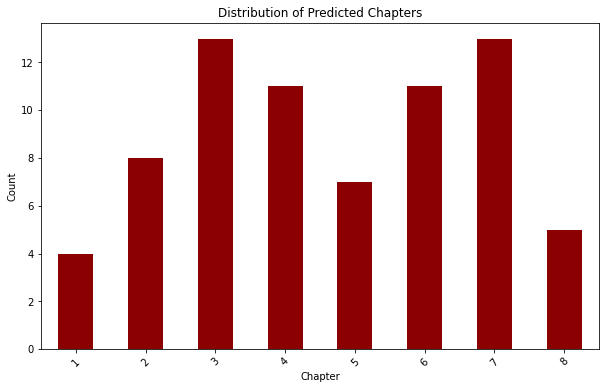

In [ ]:
# mlp = MLPClassifier(max_iter=10000, activation="relu", hidden_layer_sizes=(38))
# mlp.fit(X_train, y_train)
# get_statistics(mlp, X_test, y_test)
# comparison["MLP"] = mlp.score(X_test, y_test)

#### SVC

In [ ]:
param = {"kernel":["rbf"],
         "C": [1.5, 1.7, 2, 2.2, 2.5, 2.7],
         "gamma": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]}
grid = GridSearchCV(SVC(), param_grid=param, cv=4, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.5, 1.7, 2, 2.2, 2.5, 2.7],
                         'gamma': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
                         'kernel': ['rbf']})

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.122512,0.001035,0.062531,0.002607,1.5,0.4,rbf,"{'C': 1.5, 'gamma': 0.4, 'kernel': 'rbf'}",0.916667,0.875000,0.859155,0.816901,0.866931,0.035715,34
1,0.123411,0.004325,0.066096,0.003296,1.5,0.5,rbf,"{'C': 1.5, 'gamma': 0.5, 'kernel': 'rbf'}",0.930556,0.888889,0.859155,0.816901,0.873875,0.041535,32
2,0.128197,0.001346,0.067123,0.002125,1.5,0.6,rbf,"{'C': 1.5, 'gamma': 0.6, 'kernel': 'rbf'}",0.944444,0.902778,0.859155,0.816901,0.880820,0.047658,20
3,0.126799,0.001806,0.065355,0.002187,1.5,0.7,rbf,"{'C': 1.5, 'gamma': 0.7, 'kernel': 'rbf'}",0.944444,0.902778,0.859155,0.816901,0.880820,0.047658,20
4,0.128123,0.004942,0.060807,0.002077,1.5,0.8,rbf,"{'C': 1.5, 'gamma': 0.8, 'kernel': 'rbf'}",0.916667,0.888889,0.845070,0.816901,0.866882,0.038525,41
5,0.126186,0.007346,0.064118,0.001923,1.5,0.9,rbf,"{'C': 1.5, 'gamma': 0.9, 'kernel': 'rbf'}",0.916667,0.888889,0.845070,0.816901,0.866882,0.038525,41
6,0.125901,0.003347,0.062036,0.002544,1.5,1,rbf,"{'C': 1.5, 'gamma': 1, 'kernel': 'rbf'}",0.902778,0.902778,0.845070,0.816901,0.866882,0.037252,35
7,0.129164,0.004340,0.064704,0.000662,1.5,1.1,rbf,"{'C': 1.5, 'gamma': 1.1, 'kernel': 'rbf'}",0.902778,0.888889,0.845070,0.802817,0.859888,0.039234,43
8,0.123208,0.002712,0.060860,0.000814,1.5,1.2,rbf,"{'C': 1.5, 'gamma': 1.2, 'kernel': 'rbf'}",0.875000,0.888889,0.845070,0.802817,0.852944,0.032989,49
9,0.128423,0.006296,0.063895,0.003466,1.7,0.4,rbf,"{'C': 1.7, 'gamma': 0.4, 'kernel': 'rbf'}",0.944444,0.902778,0.859155,0.816901,0.880820,0.047658,20


In [ ]:
grid.best_params_

{'C': 2.5, 'gamma': 0.4, 'kernel': 'rbf'}

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.67      0.80         6
           2       1.00      0.70      0.82        10
           3       0.73      1.00      0.85        11
           4       0.75      0.90      0.82        10
           5       1.00      0.75      0.86         8
           6       0.90      1.00      0.95         9
           7       0.92      1.00      0.96        12
           8       0.80      0.67      0.73         6

    accuracy                           0.86        72
   macro avg       0.89      0.84      0.85        72
weighted avg       0.88      0.86      0.86        72



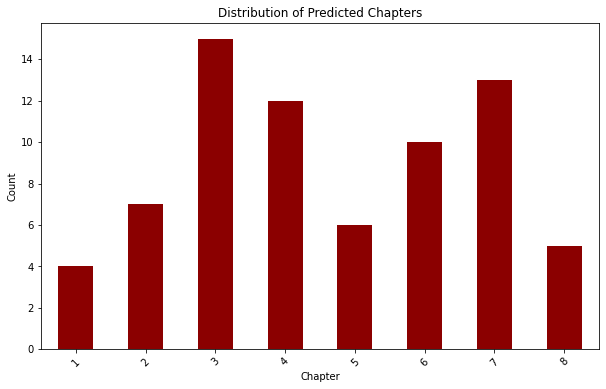

In [ ]:
svc_model = SVC(kernel='rbf', C=2.5, gamma=0.4)
svc_model.fit(X_train, y_train)
get_statistics(svc_model, X_test, y_test)
comparison["SVC"] = svc_model.score(X_test, y_test)

#### Random Forest

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.67      0.80         6
           2       0.90      0.90      0.90        10
           3       0.85      1.00      0.92        11
           4       1.00      0.70      0.82        10
           5       0.75      0.75      0.75         8
           6       0.82      1.00      0.90         9
           7       0.86      1.00      0.92        12
           8       0.80      0.67      0.73         6

    accuracy                           0.86        72
   macro avg       0.87      0.84      0.84        72
weighted avg       0.87      0.86      0.86        72



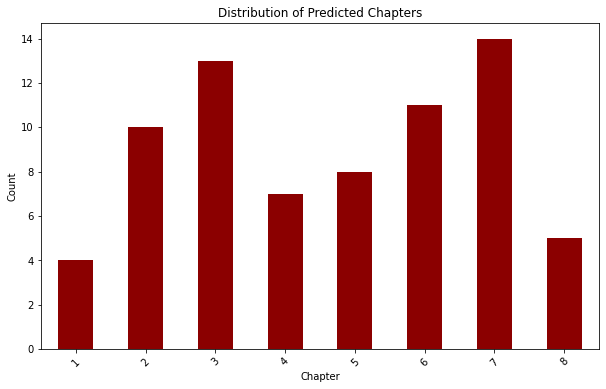

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier.fit(X_train, y_train)
get_statistics(rf_classifier, X_test, y_test)
comparison["Random Forest"] = rf_classifier.score(X_test, y_test)

#### Logistic Regression

In [ ]:
param = {"multi_class":["multinomial"],
        "C":range(1, 70)}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param, cv=4, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': range(1, 70), 'multi_class': ['multinomial']})

In [ ]:
grid.best_params_

{'C': 33, 'multi_class': 'multinomial'}

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.67      0.80         6
           2       1.00      0.70      0.82        10
           3       0.73      1.00      0.85        11
           4       0.75      0.90      0.82        10
           5       1.00      0.75      0.86         8
           6       0.90      1.00      0.95         9
           7       0.92      1.00      0.96        12
           8       0.80      0.67      0.73         6

    accuracy                           0.86        72
   macro avg       0.89      0.84      0.85        72
weighted avg       0.88      0.86      0.86        72



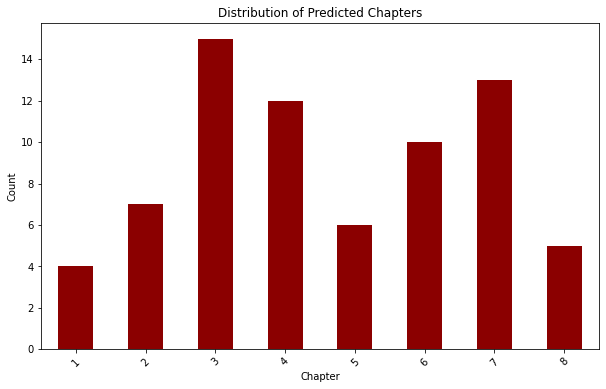

In [ ]:
logreg = LogisticRegression(max_iter=1000, multi_class="multinomial", C=33)
logreg.fit(X_train, y_train)
get_statistics(logreg, X_test, y_test)
comparison["Logistic Regression"] = logreg.score(X_test, y_test)

#### Naive Bayes

In [ ]:
param = {"alpha":[i*0.001 for i in range(1, 100)]}
grid = GridSearchCV(MultinomialNB(), param_grid=param, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006,
                                   0.007, 0.008, 0.009000000000000001, 0.01,
                                   0.011, 0.012, 0.013000000000000001, 0.014,
                                   0.015, 0.016, 0.017, 0.018000000000000002,
                                   0.019, 0.02, 0.021, 0.022, 0.023, 0.024,
                                   0.025, 0.026000000000000002, 0.027, 0.028,
                                   0.029, 0.03, ...]})

In [ ]:
grid.best_params_

{'alpha': 0.015}

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.67      0.80         6
           2       1.00      0.70      0.82        10
           3       0.73      1.00      0.85        11
           4       0.73      0.80      0.76        10
           5       0.88      0.88      0.88         8
           6       0.90      1.00      0.95         9
           7       0.92      0.92      0.92        12
           8       0.80      0.67      0.73         6

    accuracy                           0.85        72
   macro avg       0.87      0.83      0.84        72
weighted avg       0.86      0.85      0.85        72



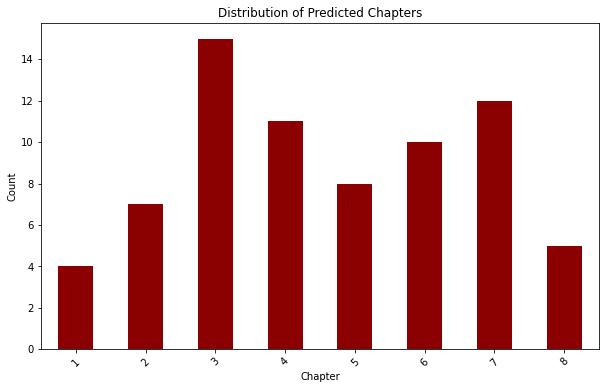

In [ ]:
nb = MultinomialNB(alpha=0.015)
nb.fit(X_train, y_train)
get_statistics(nb, X_test, y_test)
comparison["Naive Bayes"] = nb.score(X_test, y_test)

#### Comparison

In [ ]:
comparison

{'MLP': 0.8611111111111112,
 'SVC': 0.8611111111111112,
 'Random Forest': 0.8611111111111112,
 'Logistic Regression': 0.8611111111111112,
 'Naive Bayes': 0.8472222222222222}

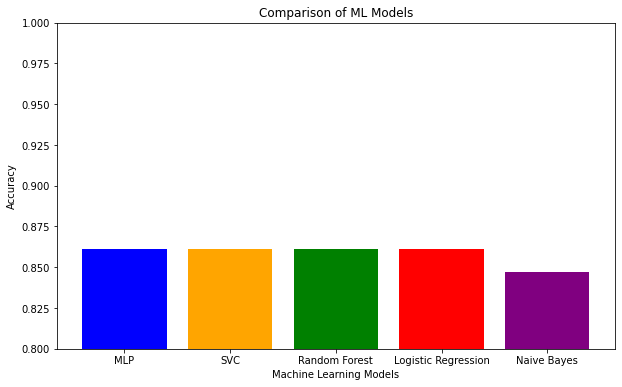

In [ ]:
models = list(comparison.keys())
accuracy = list(comparison.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Comparison of ML Models')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.ylim(0.80, 1)
plt.show()

##### Logistic Regression is the best considering its less complexity and accuracy

#### Sample prediction

In [ ]:
input_string = """virtual machines and their relationship to contemporary operating
systems. Included is a general description of the hardware and software
techniques that make virtualization possible. This chapter provides an
overview of computer networks and distributed systems, with a focus on
the Internet and TCP/IP."""
predicted_labels = predict_label(input_string, nb)

print("Predicted Labels:", predicted_labels)

Predicted Labels: ['3']


In [ ]:
for i, j in predicted_probabilities(input_string, nb):
    print(f"{i} = {j}")

0.1196065558963527 = 1
0.08921729212933385 = 2
0.6834032235164018 = 3
0.0357138933593966 = 4
0.029426299953284742 = 5
0.0007392786615803075 = 6
0.02755045964156217 = 7
0.014342996842086312 = 8


In [ ]:
input_string_2 = """In the realm of computer ethics, the concept of protecting original creations,
innovations, and expressions is paramount. This includes safeguarding the rights of creators and innovators to
control the use and distribution of their work. This protection extends to various forms of digital content,
software algorithms, databases, and other intangible assets. Ethical considerations arise in how individuals and
organizations respect these rights, avoid plagiarism or unauthorized use, and uphold the principles of fair compensation
and acknowledgment for intellectual contributions in the digital sphere."""
for i, j in predicted_probabilities(input_string_2, nb):
    print(f"{i} = {j}")

0.04908174290773743 = 1
0.3989913178913506 = 2
0.09028108994747477 = 3
0.09655319570869117 = 4
0.07167034237286014 = 5
0.004354516927378722 = 6
0.06693317514904305 = 7
0.22213461909546525 = 8


In [ ]:
dump(logreg, 'models/hci-logistic_regression.joblib')
dump(vectorizer, 'vectorizers/hci-vectorizer.joblib')

['vectorizers/hci-vectorizer.joblib']